
#   Burstiness Metrics & Threshold Classification (Human vs LLM)

**NOTE:** This is a duplicate of Burstiness-Author-AaronPressman.ipynb.

##  Purpose

This notebook is intended to extend the intial exploration of how "classifiable" the difference in this "burstiness" in a single author's work is.  In particular, I want to see if the same features that *easily* distinguished Aaron Pressman from his LLM doppleganger work on other authors.

##  Method

This exploratory notebook:
1. Loads 50 Human and 50 LLM token-probability files (`.npz`), via my custom `LogProbs` class.
2. Computes 7 burstiness metrics per document.
3. For each metric, finds a threshold that best separates Human vs LLM.
4. Compares accuracy metrics for the chosen threshold/direction.

**Datasets**
- Human: `data/tokens/human_llama-graded/reuter5050/C50train_clean/EdnaFernandes/`
- LLM (llama-graded): `data/tokens/llama70Bw4a16/reuter5050/C50train_clean/EdnaFernandes/`
- LLM (mixtral-graded): `data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean/EdnaFernandes/`

**Loader**
- `from fingerprinting_llms.score import LogProbs`
- `LogProbs.from_file(path)` with: `decoded_tokens, token_ids, token_ranks, token_probs`

In [10]:
import os, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


from fingerprinting_llms.score import LogProbs

HUMAN_DIR = "data/tokens/human_llama-graded/reuter5050/C50train_clean/EdnaFernandes/"
LLAMA_DIR   = "data/tokens/llama70Bw4a16/reuter5050/C50train_clean/EdnaFernandes/"
MIXTRAL_DIR = "data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean/EdnaFernandes/"

#   Random Number Generator
RNG = np.random.default_rng(123)


In [2]:

def load_logp_series(dir_path: str) -> list[np.ndarray]:
    """Load all .npz files from a directory and return a list of log-prob arrays (float64).
    Uses LogProbs.from_file when available; otherwise expects 'token_probs' array inside npz.
    """
    paths = sorted(glob.glob(os.path.join(dir_path, "*.npz")))
    series = []
    for p in paths:
        lp = LogProbs.from_file(p)
        token_logprobs = np.asarray(lp.token_probs, dtype=np.float64)
        series.append(token_logprobs)
    return series



## Burstiness Metrics (per document)

1. **Local Coefficient of Variation (CV\_local mean)** — mean of (std / |mean|) over rolling windows.  
This metric computes the variability of local regions of the log probabilities relative to local means, averaged over the document.  Higher values should be more "bursty", which is why we're starting out with a variance-based metric.
2. **Autocorrelation Sum (short-range)** — sum\_{k=1..K} |ρ(k)| on demeaned series (K=50).  
This measures how well the current value of the series predicts future values across short time lags.  The expectation here is that model output is more "self-similar" than human text.
3. **Spectral Entropy** — entropy of normalized FFT power spectrum (0–1).  
Looking at the frequency space, how evenly is energy is spread across the frequencies present in each sequence?  Higher spectral entropy indicates more "bursty" behavior.
4. **Variance of First Differences** — Var(Δ\_t) with Δ\_t = x\_t − x\_{t−1}.  
This is the variance of the token-by-token fluctuations across the entire document.  Expectation is that this number will be higher for human-generated text.
5. **Wavelet High-Frequency Energy Ratio** — energy in detail coefficients / total.
Decompose the signal into multiple scales via wavelet transform and measure how much energy lies in the high-frequency components.  Expectation is that human-generated should be higher.


In [3]:

def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    """Create rolling windows of an array.

    Args:
        a (np.ndarray): token log probability sequence
        window (int): size of the window for rolling calculation
        step (int, optional): step size for rolling windows

    Returns:
        np.ndarray: array of rolling windows with shape (n_windows, window_size)
    """
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def metric_local_cv_mean(x: np.ndarray, window: int = 64, step: int = 16) -> float:
    """Compute the mean of local coefficient of variation.

    Args:
        x (np.ndarray): token log probability sequence

    Returns:
        scalar coefficient of variance
    """
    w = rolling_windows(x, window, step)
    if w.size == 0:
        return np.nan
    mu = w.mean(axis=1)
    sd = w.std(axis=1, ddof=1)
    denom = np.maximum(np.abs(mu), 1e-8)
    cv = sd / denom
    return float(np.nanmean(cv))

def autocorr_abs_sum(x: np.ndarray, max_lag: int = 50) -> float:
    """Compute the sum of absolute values of autocorrelation up to max_lag.

    Args:
        x (np.ndarray): token log probability sequence

    Returns:
       float: sum of absolute values of autocorrelation up to max_lag
    """
    x = x - np.mean(x)
    var = np.var(x)
    if var < 1e-14:
        return 0.0
    s = 0.0
    for k in range(1, max_lag+1):
        num = np.dot(x[:-k], x[k:]) / (x.size - k)
        s += abs(num / var)
    return float(s)

def spectral_entropy(x: np.ndarray) -> float:
    """Compute the spectral entropy using the Fast Fourier Transform (FFT).

    Args:
        x (np.ndarray): token log probability sequence

    Returns:
        scalar spectral entropy
    """
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    # Power spectrum via FFT
    p = np.abs(np.fft.rfft(x))**2
    if p.sum() <= 0:
        return 0.0
    p /= p.sum()
    # Shannon entropy normalized by log(len)
    H = -np.sum(p * np.log(np.clip(p, 1e-45, 1.0)))
    H_norm = H / np.log(len(p))
    return float(H_norm)

def var_first_diff(x: np.ndarray) -> float:
    """Compute the variance of the first differences of the sequence.

    Args:
        x (np.ndarray): token log probability sequence

    Returns:
        scalar variance of the first differences
    """
    if x.size < 2:
        return 0.0
    d = np.diff(x)
    return float(np.var(d))

def wavelet_highfreq_ratio(x: np.ndarray) -> float:
    """Compute the ratio of high-frequency energy to total energy in the wavelet decomposition.

    Args:
        x (np.ndarray): token log probability sequence

    Returns:
        scalar fraction of frequencies that are high
    """
    x = x - x.mean()
    # Discrete Wavelet Transform; detail coeffs capture high-frequency content
    # db4 is Daubechies-4; good for smooth time series
    # Alternatives:
    #   Haar/db1: simpler, but coarse
    #   db8, db10: smoother; might smooth over important HF details
    #   Coiflets, Symlets: near-symmetric, slightly longer
    wavelet = "db4"
    max_level = pywt.dwt_max_level(len(x), pywt.Wavelet(wavelet).dec_len)
    level = max(1, min(5, max_level))
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level, mode="symmetric")
    cA, *details = coeffs  # cA = approximation; details = high-freq bands
    e_total = np.sum([np.sum(c*c) for c in coeffs])
    e_high = np.sum([np.sum(d*d) for d in details])
    return float(e_high / e_total) if e_total > 0 else 0.0
    

In [4]:

def compute_metrics_for_series(logp_list: list[np.ndarray]) -> pd.DataFrame:
    rows = []
    for idx, x in enumerate(logp_list):
        rows.append({
            "doc_id": idx,
            "cv_local_mean":       metric_local_cv_mean(x, window=64, step=16),
            "acf_abs_sum":         autocorr_abs_sum(x, max_lag=50),
            "spectral_entropy":    spectral_entropy(x),
            "var_first_diff":      var_first_diff(x),
            "wavelet_hf_ratio":    wavelet_highfreq_ratio(x),
            "n_tokens":            int(x.size)
        })
    return pd.DataFrame(rows)


In [11]:

human_series = load_logp_series(HUMAN_DIR)
llm_series   = load_logp_series(LLAMA_DIR)

df_h = compute_metrics_for_series(human_series)
df_h["label"] = "human"
df_l = compute_metrics_for_series(llm_series)
df_l["label"] = "llm"

df = pd.concat([df_h, df_l], ignore_index=True)
df


,doc_id,cv_local_mean,acf_abs_sum,spectral_entropy,var_first_diff,wavelet_hf_ratio,n_tokens,label
0,0,1.034543,1.668753,0.923533,10.755914,0.573492,498,human
1,1,1.040143,1.457494,0.932183,11.195212,0.681405,829,human
2,2,1.052708,1.499538,0.926331,13.156977,0.945103,540,human
3,3,1.038788,2.145185,0.926173,11.335789,0.593139,323,human
4,4,1.058668,1.376074,0.932560,11.751840,0.806200,726,human
...,...,...,...,...,...,...,...,...
95,45,1.267335,2.336327,0.919699,7.150513,0.202168,314,llm
96,46,1.414158,8.299651,0.854147,4.209584,0.127170,300,llm
97,47,1.355479,2.700165,0.904082,5.589896,0.529759,339,llm
98,48,1.237174,2.783902,0.896954,4.278539,0.172687,270,llm


In [6]:

def best_threshold_for_metric(values: np.ndarray, labels: np.ndarray) -> dict:
    """Find a single threshold to classify 'human' vs 'llm' using one metric.
    Tries both directions:
      - predict human if value >= thr
      - predict human if value <= thr
    Chooses the direction/threshold with the highest accuracy (ties go to first found).
    Returns performance metrics and chosen rule.
    """
    # encode: human=1, llm=0
    y = (labels == "human").astype(int)
    x = values.astype(float)
    # candidate thresholds = midpoints between sorted unique values
    xs = np.sort(np.unique(x))
    if xs.size == 1:
        thr_list = [xs[0]]
    else:
        thr_list = list((xs[:-1] + xs[1:]) / 2.0)
        thr_list = [xs[0] - 1e-9] + thr_list + [xs[-1] + 1e-9]

    best = None
    for direction in (">=", "<="):
        for thr in thr_list:
            if direction == ">=":
                yhat = (x >= thr).astype(int)
            else:
                yhat = (x <= thr).astype(int)
            acc = accuracy_score(y, yhat)
            prec = precision_score(y, yhat, zero_division=0)
            rec  = recall_score(y, yhat, zero_division=0)
            f1   = f1_score(y, yhat, zero_division=0)
            cm = confusion_matrix(y, yhat, labels=[0,1])
            result = {
                "direction": direction,
                "threshold": float(thr),
                "accuracy":  float(acc),
                "precision": float(prec),
                "recall":    float(rec),
                "f1":        float(f1),
                "confusion_matrix": cm.tolist()
            }
            if (best is None) or (acc > best["accuracy"]):
                best = result
    return best


In [12]:

metrics = ["cv_local_mean","acf_abs_sum","spectral_entropy","var_first_diff","wavelet_hf_ratio"]

results = []
for m in metrics:
    info = best_threshold_for_metric(df[m].values, df["label"].values)
    info["metric"] = m
    results.append(info)

res_df = pd.DataFrame(results)[["metric","direction","threshold","accuracy","precision","recall","f1"]]
res_df.sort_values(by="accuracy", ascending=False).reset_index(drop=True)


,metric,direction,threshold,accuracy,precision,recall,f1
0,cv_local_mean,<=,1.188559,0.96,0.960000,0.96,0.960000
1,var_first_diff,>=,9.081344,0.96,0.942308,0.98,0.960784
2,wavelet_hf_ratio,>=,0.400422,0.90,0.857143,0.96,0.905660
3,acf_abs_sum,<=,2.153480,0.87,0.911111,0.82,0.863158
4,spectral_entropy,>=,0.921214,0.85,0.948718,0.74,0.831461


##  Results - HGLG vs LGLG
Note that the directionality of the threshold indicates on which side of the threshold the human is predicted to be.

- cv_local_mean and var_first_diff were the top 2 for Aaron Pressman as well, at 0.94 and 0.97 f1 score
- The other 3 features are very close to the Aaron Pressman results as well.

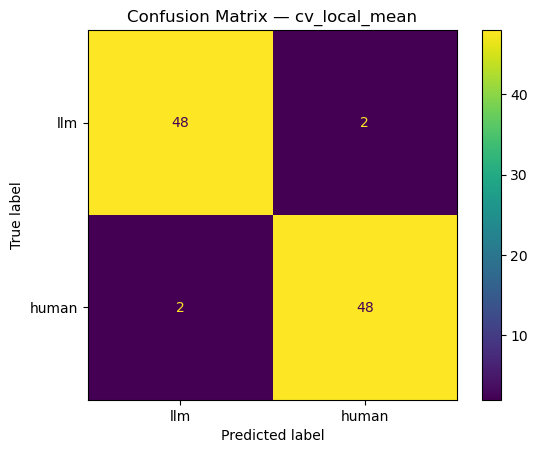

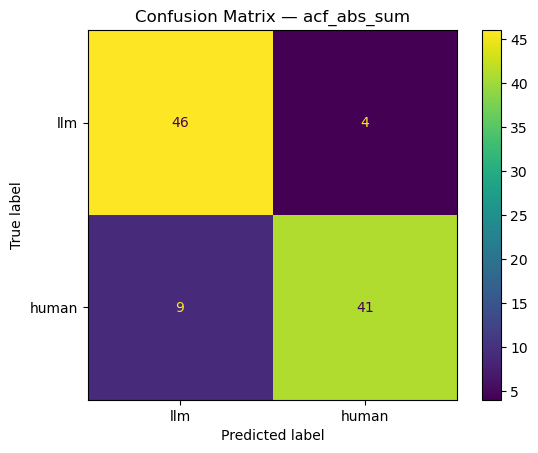

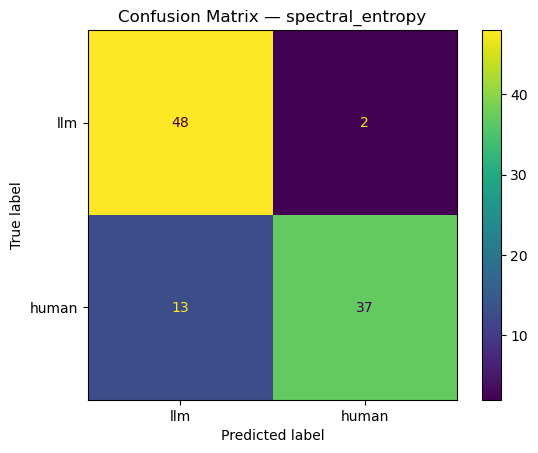

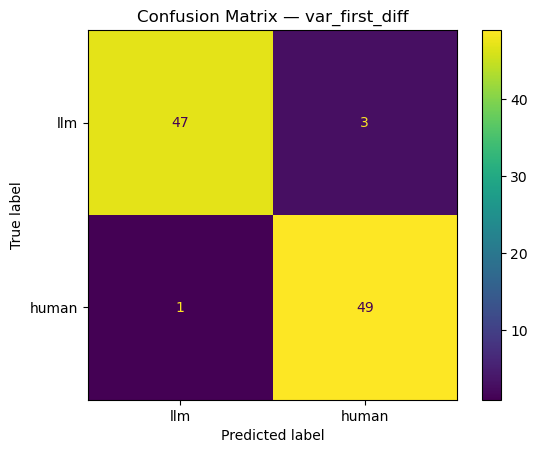

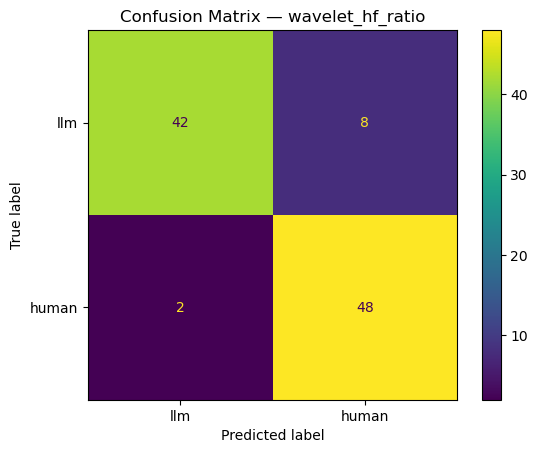

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

labels = ["llm", "human"]

for m, row in zip(res_df["metric"], results):
    cm = np.array(row["confusion_matrix"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format="d")  # counts; uses matplotlib under the hood
    plt.title(f"Confusion Matrix — {m}")
    plt.show()


##  For Kicks: 
### Let's train a Random Forest Classifer and use 5-fold Cross Validation
This isn't meant to prove anything.  I just want to see how well these metrics might work as features for a simple classifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

features = ["var_first_diff", "cv_local_mean", "acf_abs_sum",
            "wavelet_hf_ratio", "spectral_entropy"]
X = df[features].values
y = LabelEncoder().fit_transform(df["label"])  # 0=llm, 1=human

In [15]:
#   Train classifier with cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample",
)

In [16]:
#   Get results
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
cv_results = cross_validate(rf, X, y, cv=cv, scoring=scoring, return_estimator=True)
cv_summary = {metric: np.mean(cv_results[f"test_{metric}"]) for metric in scoring}

print("5-Fold Cross-Validation Performance (Random Forest)")
for k, v in cv_summary.items():
    print(f"{k:>10s}: {v:.3f}")

5-Fold Cross-Validation Performance (Random Forest)
  accuracy: 0.980
 precision: 0.982
    recall: 0.980
        f1: 0.980
   roc_auc: 0.998


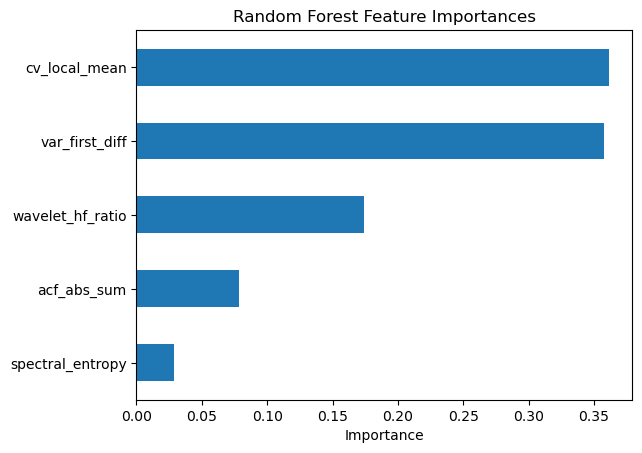

In [17]:
#   Show Feature Importances
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure()
importances.plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

## Feature Importances
These line up exactly with the most predictive 1-d thresholds we found earlier, as well as what we got from the Aaron Pressman documents.

##  Llama-Generated/Mixtral-Graded vs Human-Generated/Llama-Graded

In [18]:
mixtral_series   = load_logp_series(MIXTRAL_DIR)

df_m = compute_metrics_for_series(mixtral_series)
df_m["label"] = "llm"

df_with_mixtral = pd.concat([df_h, df_m], ignore_index=True)
df_with_mixtral

/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_24558/2243531906.py:52: RuntimeWarning: invalid value encountered in scalar divide
  num = np.dot(x[:-k], x[k:]) / (x.size - k)


,doc_id,cv_local_mean,acf_abs_sum,spectral_entropy,var_first_diff,wavelet_hf_ratio,n_tokens,label
0,0,1.034543,1.668753,0.923533,10.755914,0.573492,498,human
1,1,1.040143,1.457494,0.932183,11.195212,0.681405,829,human
2,2,1.052708,1.499538,0.926331,13.156977,0.945103,540,human
3,3,1.038788,2.145185,0.926173,11.335789,0.593139,323,human
4,4,1.058668,1.376074,0.932560,11.751840,0.806200,726,human
...,...,...,...,...,...,...,...,...
95,45,1.370438,1.761617,0.927984,7.123099,0.444976,584,llm
96,46,NaN,NaN,0.811119,6.340109,0.064402,21,llm
97,47,1.328630,1.996893,0.923091,8.094187,0.485329,593,llm
98,48,1.387629,4.591984,0.907479,8.138669,0.583478,691,llm


In [19]:

metrics = ["cv_local_mean","acf_abs_sum","spectral_entropy","var_first_diff","wavelet_hf_ratio"]

results = []
for m in metrics:
    info = best_threshold_for_metric(df_with_mixtral[m].values, df_with_mixtral["label"].values)
    info["metric"] = m
    results.append(info)

res_df = pd.DataFrame(results)[["metric","direction","threshold","accuracy","precision","recall","f1"]]
res_df.sort_values(by="accuracy", ascending=False).reset_index(drop=True)


,metric,direction,threshold,accuracy,precision,recall,f1
0,cv_local_mean,<=,1.136007,0.92,0.937500,0.90,0.918367
1,var_first_diff,>=,9.671126,0.82,0.758065,0.94,0.839286
2,acf_abs_sum,<=,1.932602,0.74,0.730769,0.76,0.745098
3,wavelet_hf_ratio,>=,0.669106,0.67,0.729730,0.54,0.620690
4,spectral_entropy,>=,0.916172,0.64,0.600000,0.84,0.700000


##  LGMG vs HGLG Results
Results consistent with the Aaron Pressman Notebook.